# Disease cross references

**Important:** You first need to run the *1.get_corss_references.py* script in order to run this notebook

In [8]:
import numpy as np
from collections import Counter
from scipy.spatial.distance import cosine as cosdist
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm_notebook as tqdm
import sys
import pandas as pd

sys.path.insert(0,'../../../../code/utils/')
import ontology as ont

col10 = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
         '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe']

xref_path = '../disease/' 

Functions

In [4]:
def get_one_hot_vectors(document2terms,universe):
    d = {}
    for document, terms in tqdm(document2terms.items(),leave=False):
        r = np.zeros(len(universe))
        r[np.searchsorted(universe, list(terms))] = 1
        d[document] = r
    return d

def get_idf_hot_vector(document2terms,universe):
    #Getting number of documents
    N = len(document2terms)
    r = []
    for x in tqdm(document2terms.values(),leave=False):
        r+=list(x)
    d = {x:(1+np.log(N/y)) for x,y in Counter(r).items()}
    return np.asarray([d[x] for x in universe])

def tfidf_one_hot_array(document2terms,universe):
    r = get_one_hot_vectors(d,universe)
    idf_vector = get_idf_hot_vector(document2terms,universe)
    return {x:r[x]*idf_vector for x in r}

### 1) Getting tfidf one hot arrays

In [6]:
sys.stderr.write('Getting tfidf vectors...\n')
d = {}
umls_universe = {}

with open(xref_path+'/disgenet.tsv','r') as f:
    f.readline()
    for l in f:

        h = l.rstrip().split('\t')
        n1,n2 = h[0],h[1]
        if n1.startswith('UMLS:'):
            if n2 not in d:
                d[n2] = set([])
            d[n2].add(n1)
            if n1 not in umls_universe:
                umls_universe[n1] = set([])
            umls_universe[n1].add(n2.split(':')[0])

        if n2.startswith('UMLS:'):
            if n1 not in d:
                d[n1] = set([])
            d[n1].add(n2)
            if n2 not in umls_universe:
                umls_universe[n2] = set([])
            umls_universe[n2].add(n1.split(':')[0])

#Only adding those MEDDRA with UMLS in common with the rest of vocabularies
with open(xref_path+'/meddra.tsv','r') as f:
    f.readline()
    for l in f:
        h = l.rstrip().split('\t')
        n1,n2 = h[0],h[1]

        if n1 in umls_universe:
            if n2 not in d:
                d[n2] = set([])
            d[n2].add(n1)
            umls_universe[n1].add(n2.split(':')[0])
        if n2 in umls_universe:
            if n1 not in d:
                d[n1] = set([])
            d[n1].add(n2)
            umls_universe[n2].add(n1.split(':')[0])

#Getting umls common universe  and filtering those terms with UMLS specific to one vocabulary
umls_universe = set([x for x in umls_universe.keys() if len(umls_universe[x])>1])
d = {x:d[x]&umls_universe for x in d.keys() if len(d[x]&umls_universe)>0}
umls_universe = sorted(umls_universe)

#Getting vectors
r = tfidf_one_hot_array(d,umls_universe)

Getting tfidf vectors...


### 2) Plotting cosine distances

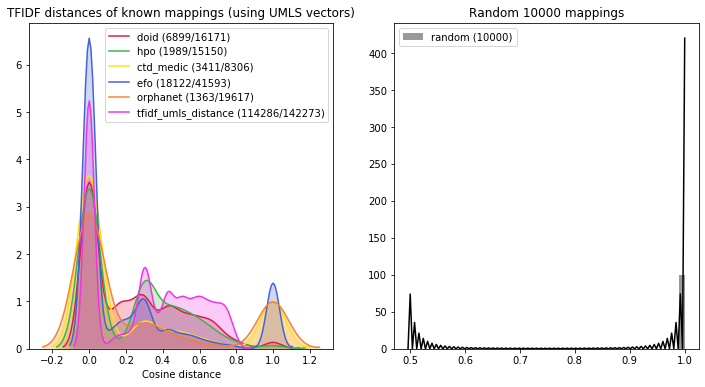

In [18]:
skip_xrfs = set(['disgenet_xrefs.tsv'])
rand = []
col = 0

fig = plt.subplots(figsize=(12,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

alreadies = set([])
below_cutoff = set([])
above_cutoff = set([])
for xrf in tqdm([xref_path+x for x in os.listdir(xref_path) if x not in skip_xrfs],desc='Ontologies'):
    name = xrf.split('/')[-1][:-4]
    c = 0
    t = 0
    with open(xrf,'r') as f:
        f.readline()
        m = []
        for l in f:
            h = l.rstrip('\n').split('\t')
            t+=1
            n1,n2 = tuple(sorted([h[0],h[1]]))
            if (n1,n2) in alreadies: continue
            alreadies.add((n1,n2))
            try:
                dist = cosdist(r[n1],r[n2])
                m.append(dist)
                if dist > 0.8:
                    above_cutoff.add(tuple(sorted((n1,n2))))
                else:
                    below_cutoff.add(tuple(sorted((n1,n2))))
                c+=1
            except KeyError:
                continue
            
        sns.distplot(m,label=name+' (%i/%i)'%(c,t),color = col10[col],hist=False,kde_kws={"shade": True},
                    ax=ax1)
        col+=1

v = list(r)
for _ in tqdm(range(10000),desc='Random'):
     rand.append(cosdist(r[np.random.choice(v)],r[np.random.choice(v)]))
sns.distplot(rand,label='random (%i)'%len(rand),color='black',
            ax=ax2)

#del rand
del m
ax1.set_xlabel('Cosine distance')
ax1.set_title('TFIDF distances of known mappings (using UMLS vectors)')
ax1.legend()

ax2.set_title('Random 10000 mappings')
ax2.legend()
plt.show()

In [13]:
v = np.array(rand)
len(v[v<0.5])/len(v)

0.0005